Zero-shot text classification is a task in natural language processing where a model is trained on a set of labeled examples but is then able to classify new examples from previously unseen classes.

In [ ]:
#Import the pipeline function from Hugging face transformers library, pipeline function is a high level API that allows you to use pre trained models for different NLP tasks
from transformers import pipeline

#creating the pipeline : The BART-large-MNLI model is a pre-trained sequence-to-sequence model that has been fine-tuned for the MNLI task, which involves determining the relationship between pairs of sentences (e.g., entailment, contradiction, or neutral).
pipe = pipeline(model="facebook/bart-large-mnli")

#using the pipeline: line of code uses the object pipe to analyze a given text and classify it into one or more of the provided labels
pipe("I have a problem with my iphone that needs to be resolved asap!",
    candidate_labels=["urgent", "not urgent", "phone", "tablet", "computer"],
)


The OUTPUT of the code above is be a dictionary with the labels and their corresponding scores, indicating the likelihood of each label being relevant to the input text.

- ex :the text is most strongly associated with the labels "urgent" and "phone" based on the scores.


Experimenting with our AIRBNB review dataset

In [ ]:

import pandas as pd
from transformers import pipeline
import torch
from pprint import pprint

# Check if GPU is available
device = 0 if torch.cuda.is_available() else -1

# Initialize the pipeline with the appropriate device
pipe = pipeline(model="facebook/bart-large-mnli", device=device)

# Load the dataset
df = pd.read_csv('/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/Small reviewdataset (10) - Sheet1.csv')

# Function to classify a single text
#explore labels like price, location, host, amenity, views, clean , quiet , parking
def classify_text(text):
    return pipe(text, candidate_labels=["location", " host", "clean",'amenity','quiet', "place", "nice"])

# Apply the classification to the dataset
df['classification'] = df['comments'].apply(classify_text)

print(df)

# Display the full classification results for each row using pprint
for index, row in df.iterrows():
    print(f"Row {index}:")
    pprint(row['classification'])
    print("\n")

Experimenting with other pre trained models that conduct other tasks


In [ ]:
# !pip install tasknet
import tasknet as tn
pipe = tn.load_pipeline('sileod/deberta-v3-small-tasksource-nli','glue/sst2') # works for 500+ tasksource tasks
pipe(['That movie was great !', 'Awful movie.'])
# [{'label': 'positive', 'score': 0.9956}, {'label': 'negative', 'score': 0.9967}]


Similiar zero shot classification that was used in first example but labels are changed to positive , neutral, and negative 

In [ ]:
from transformers import pipeline
classifier = pipeline(task="zero-shot-classification",device=0,model="facebook/bart-large-mnli"
)
classifier('This food is so good and the service is very helpful',["positive","negative",'neutral'],multi_class=True)


In [ ]:
import pandas as pd
from transformers import pipeline
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/TenThousandSampleReviewSet.csv')
# Initialize the pipeline with GPU (device=0) or CPU (device=-1) based on availability
classifier = pipeline(task="zero-shot-classification", device=0, model="facebook/bart-large-mnli")

# Function to classify a single text
def classify_text(text):
    return classifier(text, candidate_labels=["positive", "negative", "neutral"], multi_label=True)

# Apply the classification to the dataset
df['classification'] = df['comments'].apply(classify_text)

# Process classification results to get the top label for each comment
def extract_top_label(classification_result):
    scores = classification_result['scores']
    labels = classification_result['labels']
    return labels[scores.index(max(scores))]

df['top_label'] = df['classification'].apply(extract_top_label)

# Count the occurrences of each sentiment
sentiment_counts = df['top_label'].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Display the full DataFrame with classifications
print(df)

for index, row in df.iterrows():
    print(f"Row {index}:")
    pprint(row['classification'])
    print("\n")




For meeting today , 
- update Framwork (specifically the AI part , zero text classification LLM)
- work more with LLM and zero text classififcariopn 

Checkpoint 
- work with 2 differnt LLM (BERT and find one)
- run sentiment analysis with both and compare findings

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


     listing_id         id        date  reviewer_id reviewer_name  \
0           109     449036  2011-08-15       927861         Edwin   
1           109   74506539  2016-05-15     22509885          Jenn   
2          2708   13994902  2014-06-09     10905424       Kuberan   
3        183319     988343  2012-03-11      1219947     Gabriella   
4        183319  184002210  2017-08-18     70046039           Yan   
..          ...        ...         ...          ...           ...   
494        5728  144840555  2017-04-16     10854266       Corissa   
495        5728  145554102  2017-04-18     33699159        Isabel   
496        5728  148938567  2017-05-01      8901084       Karinna   
497        5728  149964877  2017-05-06     17930339      Lucienne   
498        5728  150413943  2017-05-07     57311859      Shyrynne   

                                              comments predicted_sentiment  
0    The host canceled my reservation the day befor...            negative  
1    Me and two f

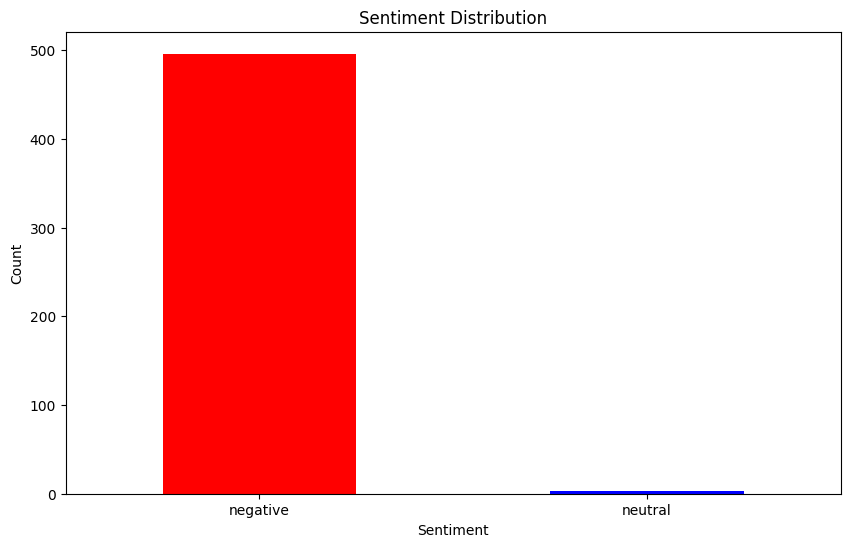

In [16]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline
import torch
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt

# Step 1: Load your dataset
df = pd.read_csv('/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/Medium sized dataset(500) - Sheet1.csv')

# Assume your dataset has a column named 'text'
texts = df['comments'].tolist()

# Step 2: Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3) # 3 labels: positive, negative, neutral

# Step 3: Tokenize and encode the sequences
def preprocess_data(texts, tokenizer, max_length=128):
    return tokenizer.batch_encode_plus(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )

encoded_data = preprocess_data(texts, tokenizer)

# Step 4: Perform sentiment analysis
model.eval()
with torch.no_grad():
    outputs = model(**encoded_data)
    predictions = torch.argmax(outputs.logits, dim=-1)

# Step 5: Convert predictions to labels
label_map = {0: 'negative', 1: 'neutral', 2: 'positive'}
predicted_labels = [label_map[pred.item()] for pred in predictions]

# Add predictions to the DataFrame
df['predicted_sentiment'] = predicted_labels

# Display the DataFrame with predictions
print(df)

# Count the occurrences of each sentiment
sentiment_counts = df['predicted_sentiment'].value_counts()

# Plot the sentiment distribution
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color=['red', 'blue', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Zero shot classificiation and Few Shot classification
- try zero shot with GPT (openAI) and with hugging face (google-T5)

In [ ]:
#Zero shot with Hugging Face

import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import matplotlib.pyplot as plt
from tqdm import tqdm 


# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

# Function to generate text labels
def generate_text_labels(texts, categories, max_new_tokens=20):
    labels = []
    text_label_mapping = {}

    # String of categories in which you want to classify the text
    category_str = ", ".join(map(str, categories))
    
    for text in texts:
        input_text = f"{text}; Classify this sentence as {category_str} in one word."
        input_ids = tokenizer(input_text, return_tensors="pt").input_ids

        outputs = model.generate(input_ids, max_new_tokens=max_new_tokens)
        label = tokenizer.decode(outputs[0], skip_special_tokens=True)
        labels.append(label)
        text_label_mapping[text] = label
    
    return labels, text_label_mapping


# Load your dataset from a CSV file
df = pd.read_csv('/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/REVIEW_datasets/TenThousandSampleReviewSet.csv')  # Replace with your file path
texts = df['comments'].tolist()  # Replace 'text_column' with the name of your text column

# Example usage with your dataset
categories = ["location", "view", "host", "amenity", "clean", "space", "privacy", "price"]
labels, text_label_mapping = generate_text_labels(texts, categories)

print("Labels:", labels)
print("Text to Label Mapping:", text_label_mapping)

# Create a DataFrame with texts and their corresponding labels
output_df = pd.DataFrame({'Text': texts, 'Label': labels})

# Save the DataFrame to a CSV file
output_csv_path = '/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/10kFinal_topicmodeling_zeroshot.csv'
output_df.to_csv(output_csv_path, index=False)


# Count the frequency of each label
label_counts = pd.Series(labels).value_counts()

# Plot the bar graph
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Save the bar graph to an image file
output_image_path = '/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/10k_topicmodeling_zeroshot_graph.png'
plt.savefig(output_image_path)

#Show graph
plt.show()





In [18]:
import pandas as pd

# Define the path to the CSV file
output_csv_path = '/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/classified_reviews.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(output_csv_path)

# Display the first few rows of the DataFrame to verify the content
print(df.head())


                                                Text     Label
0  Alex's home is truly a sanctuary.  Fantastic m...  location
1  Beautiful house, beautiful location and Alex w...  location
2  We  had a fantastic stay at Alex's Topanga San...  location
3  Alex was a great, responsive host with a wonde...     place
4  Alex was a very gracious host! WOW! What a bea...     clean


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
100%|██████████| 10001/10001 [18:17<00:00,  9.11it/s]


Filtered Labels: ['location', 'location', 'location', 'host', 'clean', 'location', 'clean', 'clean', 'location', 'location', 'location', 'location', 'location', 'location', 'location', 'location', 'location', 'location', 'location', 'location', 'location', 'location', 'location', 'location', 'location', 'location', 'location', 'clean', 'clean', 'host', 'location', 'location', 'clean', 'location', 'clean', 'location', 'clean', 'clean', 'clean', 'clean', 'clean', 'clean', 'host', 'location', 'location', 'location', 'clean', 'clean', 'host', 'location', 'host', 'location', 'location', 'location', 'location', 'location', 'location', 'clean', 'clean', 'clean', 'location', 'clean', 'clean', 'clean', 'clean', 'location', 'location', 'location', 'location', 'location', 'location', 'location', 'location', 'location', 'location', 'clean', 'host', 'location', 'location', 'location', 'clean', 'clean', 'clean', 'location', 'clean', 'clean', 'clean', 'clean', 'location', 'clean', 'location', 'clean'

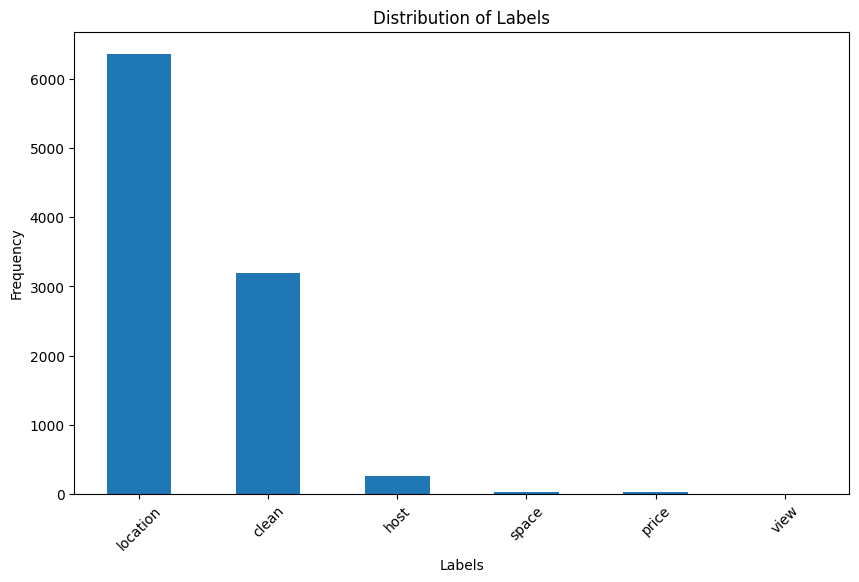

Combined outputs saved to /Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/Topic10k_FINAL_output_reviews.csv
Label distribution graph saved to /Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/Topic10k_Final_label_distribution.png


In [10]:
#Zero shot with Hugging Face (topic)
#FINAL CODE

import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

# Function to generate text labels
def generate_text_labels(texts, categories, max_new_tokens=20, max_length=512):
    labels = []
    text_label_mapping = {}

    # String of categories in which you want to classify the text
    category_str = ", ".join(map(str, categories))
    
    for text in tqdm(texts):
        # Truncate the input text if it's longer than max_length
        if len(text) > max_length:
            text = text[:max_length]

        input_text = f"{text}; Classify this sentence as {category_str} in one word."
        input_ids = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=max_length).input_ids

        outputs = model.generate(input_ids, max_new_tokens=max_new_tokens)
        label = tokenizer.decode(outputs[0], skip_special_tokens=True).lower().strip()  # Convert to lowercase and strip whitespace

        # Ensure only one label from predefined categories
        if label in categories:
            labels.append(label)
            text_label_mapping[text] = label
        else:
            # If the generated label is not in predefined categories, discard it
            labels.append(None)
            text_label_mapping[text] = None
    
    return labels, text_label_mapping

# Load your dataset from a CSV file
df = pd.read_csv('/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/REVIEW_datasets/TenThousandSampleReviewSet.csv')  # Replace with your file path
texts = df['comments'].tolist()  # Replace 'comments' with the name of your text column

# Example usage with your dataset
categories = ["location", "view", "host", "amenity", "clean", "space", "privacy", "price"]
labels, text_label_mapping = generate_text_labels(texts, categories)

# Filter out None labels
filtered_output_df = pd.DataFrame({'Text': texts, 'Labels': labels})
filtered_output_df = filtered_output_df.dropna()

print("Filtered Labels:", filtered_output_df['Labels'].tolist())
print("Text to Label Mapping:", text_label_mapping)

# Define the path to save the CSV file
output_csv_path = '/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/Topic10k_FINAL_output_reviews.csv'

# Save the filtered DataFrame to a CSV file
filtered_output_df.to_csv(output_csv_path, index=False)

# Count the frequency of each label
label_counts = filtered_output_df['Labels'].value_counts()

# Print the frequency of each label
print("Label counts:")
print(label_counts)

# Plot the bar graph
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Save the bar graph to an image file
output_image_path = '/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/Topic10k_Final_label_distribution.png'
plt.savefig(output_image_path)

plt.show()

print(f"Combined outputs saved to {output_csv_path}")
print(f"Label distribution graph saved to {output_image_path}")










In [ ]:
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

# Function to generate text labels
def generate_text_labels(texts, categories, max_new_tokens=20, max_length=512, batch_size=32):
    labels = []
    text_label_mapping = {}

    # String of categories in which you want to classify the text
    category_str = ", ".join(map(str, categories))

    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        input_texts = [f"{text}; Classify this sentence as {category_str} in one word." for text in batch_texts]
        inputs = tokenizer(input_texts, return_tensors="pt", truncation=True, padding=True, max_length=max_length)

        # Move tensors to the GPU if available
        input_ids = inputs.input_ids.to('cuda') if torch.cuda.is_available() else inputs.input_ids

        outputs = model.generate(input_ids, max_new_tokens=max_new_tokens)
        batch_labels = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]

        labels.extend(batch_labels)
        text_label_mapping.update({text: label for text, label in zip(batch_texts, batch_labels)})

    return labels, text_label_mapping

# Load your dataset from a CSV file
df = pd.read_csv('/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/REVIEW_datasets/TenThousandSampleReviewSet.csv')  # Replace with your file path
texts = df['comments'].tolist()  # Replace 'comments' with the name of your text column

# Example usage with your dataset
categories = ['positvie', 'negative', 'neutral']
labels, text_label_mapping = generate_text_labels(texts, categories)

print("Labels:", labels)
print("Text to Label Mapping:", text_label_mapping)

# Add the different outputs as new columns
output_df = pd.DataFrame({'Text': texts, 'Labels': labels})

# Define the path to save the CSV file, including the filename
output_csv_path = '/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/Topic_FINAL_output_reviews.csv'

# Extract the directory path from the full file path
output_dir = os.path.dirname(output_csv_path)

# Create the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Save the DataFrame to a CSV file
output_df.to_csv(output_csv_path, index=False)

# Count the frequency of each label
label_counts = pd.Series(labels).value_counts()

# Plot the bar graph
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Save the bar graph to an image file
output_image_path = '/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/Topic_Final_label_distribution.png'
plt.savefig(output_image_path)

plt.show()

print(f"Final topic outputs saved to {output_csv_path}")
print(f"Topic Label distribution graph saved to {output_image_path}")

Avengers


In [ ]:
import torch
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

# Function to generate text labels
def generate_text_labels(texts, categories, max_new_tokens=20, max_length=512, batch_size=32):
    labels = []
    text_label_mapping = {}

    # String of categories in which you want to classify the text
    category_str = ", ".join(map(str, categories))
    
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size]
        input_texts = [f"{text}; Classify this sentence as {category_str} in one word." for text in batch_texts]
        inputs = tokenizer(input_texts, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
        
        # Move tensors to the GPU if available
        input_ids = inputs.input_ids.to('cuda') if torch.cuda.is_available() else inputs.input_ids
        
        outputs = model.generate(input_ids, max_new_tokens=max_new_tokens)
        batch_labels = [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]
        
        labels.extend(batch_labels)
        text_label_mapping.update({text: label for text, label in zip(batch_texts, batch_labels)})
    
    return labels, text_label_mapping

# Load your dataset from a CSV file
df = pd.read_csv('/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/processed_review_data.csv')  # Replace with your file path
texts = df['comments'].tolist()  # Replace 'comments' with the name of your text column

# Example usage with your dataset
categories = ["location", "host", "clean", "amenity", "quiet", "place"]
labels, text_label_mapping = generate_text_labels(texts, categories)

print("Labels:", labels)
print("Text to Label Mapping:", text_label_mapping)

# Add the different outputs as new columns
output_df = pd.DataFrame({'Text': texts, 'Labels': labels})

# Define the path to save the CSV file
output_csv_path = '/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/Topic_FINAL_output_reviews.csv'

# Save the DataFrame to a CSV file
output_df.to_csv(output_csv_path, index=False)

# Count the frequency of each label
label_counts = pd.Series(labels).value_counts()

# Plot the bar graph
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Save the bar graph to an image file
output_image_path = '/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/Topic_Final_label_distribution.png'
plt.savefig(output_image_path)

plt.show()

print(f"Combined outputs saved to {output_csv_path}")
print(f"Label distribution graph saved to {output_image_path}")


In [16]:
import pandas as pd

# Load your dataset from a CSV file
df = pd.read_csv('/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/REVIEW_datasets/TenThousandSampleReviewSet.csv')  # Replace with your file path

# Print the column names
print(df.columns)


Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments',
       'clean_comments'],
      dtype='object')


In [17]:
import pandas as pd

# Load your additional 200 labeled reviews from another CSV file
df_200 = pd.read_csv('/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/ManuelCoding200_(YG) - Copy(Sheet1) id cleaned up(in).csv')  # Replace with your file path

# Print the column names
print(df_200.columns)


Index(['listing_id', 'id', 'date', 'reviewer_id', 'reviewer_name', 'comments',
       'clean_comments', 'Sentiment ',
       'Location / neighborhood (including quiet)', 'View ',
       'Host /Communication', 'Amenities (pool, parking, balcony)',
       'Cleanliness ', 'Space', 'Privacy', 'Value / Price',
       'POI (Point of Interest)', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19',
       'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23',
       'Unnamed: 24', 'Unnamed: 25'],
      dtype='object')


CODE below to try to run both sentiment and topic modeling simultaneously

In [ ]:
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import matplotlib.pyplot as plt

# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

# Function to generate text labels
def generate_text_labels(texts, categories, max_new_tokens=20):
    labels = []
    text_label_mapping = {}

    # String of categories in which you want to classify the text
    category_str = ", ".join(map(str, categories))
    
    for text in texts:
        input_text = f"{text}; Classify this sentence as {category_str} in one word."
        input_ids = tokenizer(input_text, return_tensors="pt").input_ids

        outputs = model.generate(input_ids, max_new_tokens=max_new_tokens)
        label = tokenizer.decode(outputs[0], skip_special_tokens=True)
        labels.append(label)
        text_label_mapping[text] = label
    
    return labels, text_label_mapping

# Load your dataset from a CSV file
df = pd.read_csv('/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/processed_review_data.csv')  # Replace with your file path
texts = df['comments'].tolist()  # Replace 'comments' with the name of your text column

# Example usage with your dataset
categories = ["location", "host", "clean", "amenity", "quiet", "place"]
labels_1, text_label_mapping_1 = generate_text_labels(texts, categories)

# Another set of categories or another analysis
categories_2 = ["positive", "negative", "neutral"]
labels_2, text_label_mapping_2 = generate_text_labels(texts, categories_2)

# Create a DataFrame with texts
output_df = pd.DataFrame({'Text': texts})

# Add the different outputs as new columns
output_df['Labels_1'] = labels_1
output_df['Labels_2'] = labels_2

# Display the DataFrame to verify
print(output_df.head())

# Define the path to save the CSV file
output_csv_path = '/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/FINALcombined_output_reviews.csv'

# Save the DataFrame to a CSV file
output_df.to_csv(output_csv_path, index=False)

print(f"Combined outputs saved to {output_csv_path}")

#Count the frequency of each label for Labels_1
label_counts_1 = output_df['Labels_1'].value_counts()

# Count the frequency of each label for Labels_2
label_counts_2 = output_df['Labels_2'].value_counts()

# Plot the bar graph for Labels_1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
label_counts_1.plot(kind='bar')
plt.title('Distribution of Labels 1')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Plot the bar graph for Labels_2
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
label_counts_2.plot(kind='bar')
plt.title('Distribution of Labels 2')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

# Save the bar graph to an image file
output_image_path = '/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/Final_label_distribution.png'
plt.savefig(output_image_path)

plt.show()



Few shot classification with hugging face -google t5

In [ ]:
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

# Function to generate text labels with context
def generate_text_labels_context(texts, context, max_new_tokens=20, max_length=512):
    labels = []
    text_label_mapping = {}

    # Create context string from labeled reviews
    context_string = ""
    for sentence, sentiment in context:
        context_string += f"Text: {sentence}\nSentiment: {sentiment}\n"

    for text in tqdm(texts):
        # Truncate the input text if it's longer than max_length
        if len(text) > max_length:
            text = text[:max_length]

        input_text = f"{context_string}\nBased on the above examples, determine the sentiment of the following sentence.\nText: {text}\nSentiment:"
        input_ids = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=max_length).input_ids

        outputs = model.generate(input_ids, max_new_tokens=max_new_tokens)
        label = tokenizer.decode(outputs[0], skip_special_tokens=True).lower().strip()  # Convert to lowercase and strip whitespace

        # Ensure only one label from predefined categories
        if label in ["positive", "neutral", "negative"]:
            labels.append(label)
            text_label_mapping[text] = label
        else:
            labels.append(None)
            text_label_mapping[text] = None
    
    return labels, text_label_mapping

# Load your 10k dataset from a CSV file
df_10k = pd.read_csv('/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/REVIEW_datasets/TenThousandSampleReviewSet.csv')  # Replace with your file path
texts_10k = df_10k['comments'].tolist()  # Replace 'comments' with the name of your text column

# Load your additional 200 labeled reviews from another CSV file
df_200 = pd.read_csv('/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/REVIEW_datasets/100_of_10k_reviews - Sheet1-2.csv')  # Replace with your file path
texts_200 = df_200['comments'].tolist()  # Replace 'comments' with the name of your text column
labels_200 = df_200['Sentiment '].tolist()  # Replace 'label' with the name of your label column

# Create context from 200 labeled reviews
context = list(zip(texts_200, labels_200))

# Example usage with your 10k dataset
categories = ["positive", "neutral", "negative"]
labels, text_label_mapping = generate_text_labels_context(texts_10k, context)

# Filter out None labels
filtered_output_df = pd.DataFrame({'Text': texts_10k, 'Labels': labels})
filtered_output_df = filtered_output_df.dropna()

print("Filtered Labels:", filtered_output_df['Labels'].tolist())
print("Text to Label Mapping:", text_label_mapping)

#Define the path to save the CSV file
output_csv_path = '/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/fewshotattempt_reviews.csv'
# Save the filtered DataFrame to a CSV file
filtered_output_df.to_csv(output_csv_path, index=False)

# Count the frequency of each label
label_counts = filtered_output_df['Labels'].value_counts()

# Print the frequency of each label
print("Label counts:")
print(label_counts)

# Plot the bar graph
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

#Save the bar graph to an image file
output_image_path = '/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/fewshotattempt_reviews.png'
plt.savefig(output_image_path)

plt.show()

print(f"Combined outputs saved to {output_csv_path}")
print(f"Label distribution graph saved to {output_image_path}")



In [50]:
import pandas as pd

# Load your dataset (replace 'your_dataset.csv' with the actual file path)
df = pd.read_csv('/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/REVIEW_datasets/Small reviewdataset (10) - Sheet1.csv')

# Convert the "comments" column to a list
reviews_list = df['comments'].tolist()

# Now, reviews_list contains all the reviews from the "comments" column in a single list
print(reviews_list)


['David is a great host. The apartment was pretty much ideal for our needs as we could walk to relations house.\n<br/>It had everything..\n<br/>\n<br/>Thanks David.', 'This little apartment is very cute and well appointed. Everything you need is walking distance  and the endless hotel water in the place was a real treat. Highly recommended.', "David's place was great.   Clean, looked just like the pictures, easy check in & out.  Nice neighborhood, convenient, close to the freeway, Griffith Park. Would stay again.\n<br/>", 'Great location.  Great neighborhood.  Very relaxing!!', 'David was great! he responded to my request very quickly and he was very accomodating. the house was so wonderful!  we had a nice dinner outside in the backyard and everything we needed was already in the kitchen ;)  david had all kinds of useful info about the area and places we could tour around town. the area was quiet and parking was easy. i would for sure stay here again! this house is lovely and wonderful

In [51]:
import pandas as pd

# Load your dataset (replace 'your_dataset.csv' with the actual file path)
df = pd.read_csv('/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/ManuelCoding200_(YG) - Copy(Sheet1) id cleaned up(in).csv')

# Combine the "comments" and "sentiment" columns into a list of tuples
comment_sentiment_tuples = list(zip(df['comments'], df['Sentiment']))

# Now, comment_sentiment_tuples contains each comment paired with its sentiment in tuple format
print(comment_sentiment_tuples)


[('Alex was a great, responsive host with a wonderful home. I would recommend to anyone!', 1), ('Lovely and comfortable, and a great outside area! Thanks for hosting us!', 1), ('"We had a wonderful stay in Ari\'s apartment. The apartment is awesome! The bed very comfortable, and this big rain shower: OMG!:-) <br/>There were a lot of little attentions, like delicious chocolats, beverages in the fridge, Nespresso coffee, even he let us a bottle of champagne because it was our Honeymoon! <br/>The area is pretty nice, short walking distance to bus stop and westwood village (where are a lot of restaurants and any bars). Within 3 Minutes drive you are on the freeway and Highway. <br/>We have not met Ari, but we met his wife Shab who shows us the apartment. With both we had a very nice contact. They responded quickly to my mails and questions. <br/>My husband and me highly recommend this apartment!!"', 1), ('Lovely and comfortable, and a great outside area! Thanks for hosting us!', 1), ('Terr

In [2]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

# Few-Shot Learning function
def generate_text_labels_context(text, context):
    labels = []
    text_label_mapping = {}
    
    # Create context string from examples
    context_string = ""
    for example in context:
        context_string += f"Text: {example[0]}\nSentiment: {example[1]}\n"

    for sentence in text:
        # Create input text for the model
        input_text = f"{context_string} \nBased on the above examples determine the sentiment of the following sentence. \nText: {sentence} \nSentiment:"
        input_ids = tokenizer(input_text, return_tensors="pt").input_ids

        # Generate output from the model
        outputs = model.generate(input_ids)
        label = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
        labels.append(label)
        text_label_mapping[sentence] = label
    
    return labels, text_label_mapping

# Example input
text = ['David is a great host. The apartment was pretty much ideal for our needs as we could walk to relations house.\n<br/>It had everything..\n<br/>\n<br/>Thanks David.', 'This listing was extremely misleading. We frequently rent AirbnbÃ¢Â€Â™s for our employees all over the country. Upon arrival there were other guests staying in other parts of the same house and other people on the property seemingly. Nothing was very clear. I was told it was per friendly but the host called Airbnb and tried to have us leave after one day because the dog that travels with my crew was barking too much and disturbing people. Well i thought i rented an Ã¢Â€Âœentire placeÃ¢Â€Â. We worked that out and then he sent me a video where you hear a small dog who is 15 btw, let out a bark maybe twice in 3 minutes - he said it was bothering other guests- he didnÃ¢Â€Â™t realize the dog would be left alone while we were out. And basically the host was on the property tending to a pile of old things outside that he needed to sort out. There was no real light in the place - only pink and blue lights. The bedroom has zero lights and we had to bring in a utility light from one of our jobs to see. The house is so secluded on the top of a mountain that once we were back at the house from work there was no leaving until the next day. My employees who travel for us often said it was the worst experience they have ever had at an Airbnb. And ended up leaving two days early and getting their own hotel rooms because of our uncomfortable they were. This house is basically for someone who wants to live on a commune and hang out with the host.' "Davids place was great. Clean, looked just like the pictures, easy check in & out.  Nice neighborhood, convenient, close to the freeway, Griffith Park. Would stay again.\n<br/>", 'Mixed feelings on our experience here. Jay was fairly easy to communicate with. The location was fantastic .. Steps from rodeo drive which was convenient for the price point & was great that parking was included. The building looks pretty from the outside but it smells on the inside. The apartment itself was a good size, but I found it to be dirty, there was hairs on the floor /the bed/ the couch .. & the bathroom wasnt very clean. We slept on top of the sheets & the bed wasnt comfortable and had small pillows. Someone was knocking on door beside us at 8am for an hour ... <br/>Ultimately, If there was a new bed & a proper cleaning job done it would be a much nicer stay.', 'David was great! he responded to my request very quickly and he was very accomodating. the house was so wonderful!  we had a nice dinner outside in the backyard and everything we needed was already in the kitchen ;)  david had all kinds of useful info about the area and places we could tour around town. the area was quiet and parking was easy. i would for sure stay here again! this house is lovely and wonderful. would recommend a stay her for EVERYONE ;)', 'The Spanish Bungalow Guest House was a fabulous place to stay. It had everything we needed and more. Great location. David was very friendly and made us feel welcome immediately. Lots of great tips about the area - and a real gentleman -- noticed our Smart Car with canadian plates when we were on the highway approaching his place - and gave us the personal escort! Excellent experience with airbnb - will definitely continue to use the services provided through this site.', 'Cute place. David is a sweet person and the neighborhood is quiet clean and hip.', 'David was a great host.. He was very nice and his place did not disappoint.. It looked just like the pictures!', 'Cozy and cute bungalow in a nice, quiet neighborhood, accessible to lots of great LA spots. David is a great host. The house is small but adorable and has everything you need for a great stay.', "This is our first time using Airbnb. We had the best time! David's little bunglow is adorable and close to everything! The neighborhood is very nice and quiet. Even though we have family that live in LA and could stay somewhere for free, I would rather come back and stay here! It is the perfect little getaway. :)"]
#context = [("The bed was comfortable.", "positive"), ("The WiFi was slow.", "negative"), ("The location was convenient.", "positive")]
context = [('Great location. Very clean cute little cottage. Many extras from fully stocked kitchen, shampoo conditioner, washer dyer to use and great welcome basket. Would recommend this listing', 'positvie'),('As I read through the prior reviews, I am torn about how I should communicate my thoughts about my stay.  I would say that, on the one hand, the neighborhood is beautiful, the location is accessible to great areas of Los Angeles, and the parking is very easy, safe, and free.  The host is very responsive and there was never anything I was lacking.  The value is also great. And the pool and spa are spectacular, which is really the biggest plus when its so hot in LA.  On the other hand, I did experience some mixed feelings about the quality and appearance of the towels, sheets, pillows, and other appointments of the place.  One of the sheets was torn, the comforter cover did not look clean, I did not personally like the pillows (though other guests have raved about them), and the towels were worn, mismatched, and looked like they were not clean.  The bathmat appeared not to have been washed during the last 20 stays!  I know other hosts who replace all of these items every few months.  At TJ Maxx or other such places, you can get towels, washcloths and bathmats for $10 each, so I would really encourage the host to consider this.  So, this is the reason why I could not go as far as the other guests did with the raves, but the place is really a great find and I want to make sure I show some love for it - I hope I have.','neutral'),('Host cancelled few hours before our checkin. We had to find a new place.','negative')]

# Generate labels
labels, text_label_mapping = generate_text_labels_context(text, context)

# Print the results
print("Labels:", labels)
print("Text to Label Mapping:", text_label_mapping)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/.venv/lib/python3.12/site-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (791 > 512). Running this sequence through the model will result in indexing errors


Labels: ['positive', 'negative', 'negative', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive']
Text to Label Mapping: {'David is a great host. The apartment was pretty much ideal for our needs as we could walk to relations house.\n<br/>It had everything..\n<br/>\n<br/>Thanks David.': 'positive', 'This listing was extremely misleading. We frequently rent AirbnbÃ¢Â€Â™s for our employees all over the country. Upon arrival there were other guests staying in other parts of the same house and other people on the property seemingly. Nothing was very clear. I was told it was per friendly but the host called Airbnb and tried to have us leave after one day because the dog that travels with my crew was barking too much and disturbing people. Well i thought i rented an Ã¢Â€Âœentire placeÃ¢Â€Â\x9d. We worked that out and then he sent me a video where you hear a small dog who is 15 btw, let out a bark maybe twice in 3 minutes - he said it was bothering other guests- he didnÃ¢Â€

500 sized dataset attempt

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/.venv/lib/python3.12/site-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors


Labels: ['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'negative', 'negative', 'negative', 'positive', 'positive', 'positi

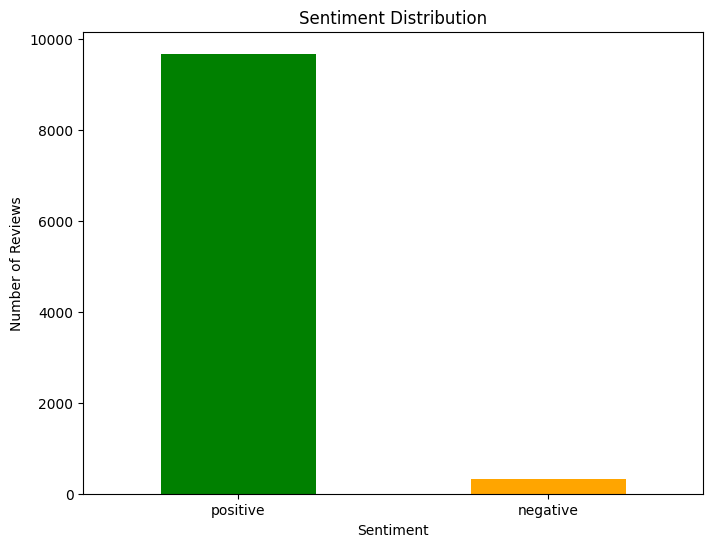

In [7]:
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

# Few-Shot Learning function
def generate_text_labels_context(text, context):
    labels = []
    text_label_mapping = {}
    
    # Create context string from examples
    context_string = ""
    for example in context:
        context_string += f"Text: {example[0]}\nSentiment: {example[1]}\n"

    for sentence in text:
        # Create input text for the model
        input_text = f"{context_string} \nBased on the above examples determine the sentiment of the following sentence. \nText: {sentence} \nSentiment:"
        input_ids = tokenizer(input_text, return_tensors="pt").input_ids

        # Generate output from the model
        outputs = model.generate(input_ids)
        label = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
        labels.append(label)
        text_label_mapping[sentence] = label
    
    return labels, text_label_mapping

# Load your dataset with 500 reviews (replace 'your_dataset.csv' with the actual file path)
df = pd.read_csv('/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/REVIEW_datasets/TenThousandSampleReviewSet.csv')
text = df['comments'].tolist()  # Extract the comments column

# Keep the context the same as before
context = [
    ('Great location. Very clean cute little cottage. Many extras from fully stocked kitchen, shampoo conditioner, washer dyer to use and great welcome basket. Would recommend this listing', 'positive'),
    ('As I read through the prior reviews, I am torn about how I should communicate my thoughts about my stay.  I would say that, on the one hand, the neighborhood is beautiful, the location is accessible to great areas of Los Angeles, and the parking is very easy, safe, and free.  The host is very responsive and there was never anything I was lacking.  The value is also great. And the pool and spa are spectacular, which is really the biggest plus when its so hot in LA.  On the other hand, I did experience some mixed feelings about the quality and appearance of the towels, sheets, pillows, and other appointments of the place.  One of the sheets was torn, the comforter cover did not look clean, I did not personally like the pillows (though other guests have raved about them), and the towels were worn, mismatched, and looked like they were not clean.  The bathmat appeared not to have been washed during the last 20 stays!  I know other hosts who replace all of these items every few months.  At TJ Maxx or other such places, you can get towels, washcloths and bathmats for $10 each, so I would really encourage the host to consider this.  So, this is the reason why I could not go as far as the other guests did with the raves, but the place is really a great find and I want to make sure I show some love for it - I hope I have.', 'neutral'),
    ('Host cancelled few hours before our checkin. We had to find a new place.', 'negative')
]

# Generate labels using the model
labels, text_label_mapping = generate_text_labels_context(text, context)

# Print the results
print("Labels:", labels)
print("Text to Label Mapping:", text_label_mapping)

# Save the generated labels to a CSV file
output_df = pd.DataFrame({'Text': text, 'Generated_Sentiment': labels})
output_csv_path = '/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/10kFewshotattempt.csv'
output_df.to_csv(output_csv_path, index=False)
print(f"Generated labels saved to {output_csv_path}")

# Count the occurrences of each sentiment
label_counts = pd.Series(labels).value_counts()

# Plot a bar chart of the sentiment distribution
plt.figure(figsize=(8, 6))
label_counts.plot(kind='bar', color=['green', 'orange', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)

# Save the plot to a PNG file
output_png_path = 'Fewshotsentiment_distribution.png'
plt.savefig(output_png_path)
print(f"Sentiment distribution chart saved to {output_png_path}")

# Display the plot
plt.show()



In [48]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

# Few-Shot Learning function
def generate_text_labels_context(text, context):
    labels = []
    text_label_mapping = {}
    
    # Create context string from examples
    context_string = ""
    for example in context:
        context_string += f"Text: {example[0]}\nSentiment: {example[1]}\n"

    for sentence in text:
        # Create input text for the model
        input_text = f"{context_string} \nBased on the above examples determine the sentiment of the following sentence. \nText: {sentence} \nSentiment:"
        input_ids = tokenizer(input_text, return_tensors="pt").input_ids

        # Generate output from the model
        outputs = model.generate(input_ids)
        label = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
        labels.append(label)
        text_label_mapping[sentence] = label
    
    return labels, text_label_mapping

# Example input
text = ["The room was clean and spacious.", "The view was breathtaking.", "The host was rude."]
context = [("The bed was comfortable.", "positive"), ("The WiFi was slow.", "negative"), ("The location was convenient.", "positive")]

# Generate labels
labels, text_label_mapping = generate_text_labels_context(text, context)

# Print the results
print("Labels:", labels)
print("Text to Label Mapping:", text_label_mapping)




Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/.venv/lib/python3.12/site-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Labels: ['positive', 'positive', 'negative']
Text to Label Mapping: {'The room was clean and spacious.': 'positive', 'The view was breathtaking.': 'positive', 'The host was rude.': 'negative'}


In [49]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
import pandas as pd

# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

# Few-Shot Learning function
def generate_text_labels_context(texts, context, max_new_tokens=20, max_length=512):
    labels = []
    text_label_mapping = {}
    
    # Create context string from examples
    context_string = ""
    for example in context:
        context_string += f"Text: {example[0]}\nSentiment: {example[1]}\n"

    for text in texts:
        # Truncate the input text if it's longer than max_length
        if len(text) > max_length:
            text = text[:max_length]

        # Create input text for the model
        input_text = f"{context_string}\nText: {text}\nSentiment:"
        input_ids = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=max_length).input_ids

        # Generate output from the model
        outputs = model.generate(input_ids, max_new_tokens=max_new_tokens)
        label = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()

        # Clean up the label to remove any unwanted prefixes
        if "Sentiment:" in label:
            label = label.split("Sentiment:")[-1].strip()
        
        # Only use the label if it matches one of the expected categories
        if label in ["positive", "neutral", "negative"]:
            labels.append(label)
            text_label_mapping[text] = label
        else:
            print(f"Unrecognized label: {label}")
    
    return labels, text_label_mapping

# Load your datasets
# Labeled dataset to use as context
labeled_df = pd.read_csv('/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/ManuelCoding200_(YG) - Copy(Sheet1) id cleaned up(in).csv')
context = list(zip(labeled_df['comments'], labeled_df['Sentiment']))  # Replace 'comments' and 'Sentiment' with the column names

# Unlabeled dataset to generate labels
#unlabeled_df = pd.read_csv('/path/to/unlabeled_dataset.csv')
#texts = unlabeled_df['comments'].tolist()  # Replace 'comments' with the name of your text column

# Generate labels
labels, text_label_mapping = generate_text_labels_context(texts, context)

# Print the results
print("Generated Labels:", labels)
print("Text to Label Mapping:", text_label_mapping)

# Add the different outputs as new columns
#output_df = pd.DataFrame({'Text': texts, 'Generated_Sentiment': labels})

# Define the path to save the CSV file
#output_csv_path = '/path/to/output_file.csv'

# Save the DataFrame to a CSV file
#output_df.to_csv(output_csv_path, index=False)

#print(f"Combined outputs saved to {output_csv_path}")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecognized label: 4
Unrecogniz

KeyboardInterrupt: 

In [47]:
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch

# Load the tokenizer and model
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-base")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-base")

# Function to generate text labels with context
def generate_text_labels_context(texts, context, max_new_tokens=20, max_length=512):
    labels = []
    text_label_mapping = {}
    
    # Prepare context string
    context_string = ""
    for example in context:
        context_string += f"Text: {example[0]}\nSentiment: {example[1]}\n"
    
    for text in texts:
        # Truncate the input text if it's longer than max_length
        if len(text) > max_length:
            text = text[:max_length]

        input_text = f"{context_string}\nText: {text}\nSentiment:"
        input_ids = tokenizer(input_text, return_tensors="pt", truncation=True, max_length=max_length).input_ids

        outputs = model.generate(input_ids, max_new_tokens=max_new_tokens)
        label = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
        
        # Clean up the label to remove any unwanted prefixes
        if "Sentiment:" in label:
            label = label.split("Sentiment:")[-1].strip()
        
        # Only use the label if it matches one of the expected categories
        if label in ['4', "neutral", "negative"]:
            labels.append(label)
            text_label_mapping[text] = label
        else:
            print(f"Unrecognized label: {label}")

    return labels, text_label_mapping

# Load your datasets
# Unlabeled dataset
unlabeled_df = pd.read_csv('/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/REVIEW_datasets/Medium sized dataset(500) - Sheet1.csv')
texts = unlabeled_df['comments'].tolist()  # Replace 'comments' with the name of your text column

# Labeled dataset
labeled_df = pd.read_csv('/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/ManuelCoding200_(YG) - Copy(Sheet1) id cleaned up(in).csv')
context = list(zip(labeled_df['comments'], labeled_df['Sentiment']))  # Replace 'comments' and 'Sentiment' with the column names

# Example usage with your dataset
labels, text_label_mapping = generate_text_labels_context(texts, context)

print("Generated Labels:", labels)
print("Text to Label Mapping:", text_label_mapping)

# Ensure the lengths match
if len(texts) == len(labels):
    # Add the different outputs as new columns
    output_df = pd.DataFrame({'Text': texts, 'Generated_Sentiment': labels})

    # Define the path to save the CSV file
    #output_csv_path = '/path/to/Fewshotattempt.csv'

    # Save the DataFrame to a CSV file
    output_df.to_csv(output_csv_path, index=False)

    print(f"Combined outputs saved to {output_csv_path}")
else:
    print("Error: The number of texts and the number of generated labels do not match.")
    print(f"Number of texts: {len(texts)}")
    print(f"Number of labels: {len(labels)}")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


KeyboardInterrupt: 

In [51]:
import pandas as pd
from sklearn.metrics import classification_report
from setfit import SetFitModel, SetFitTrainer
from datasets import Dataset

# Load your dataset from a CSV file
# Ensure your CSV file has columns named 'comments' and 'Sentiment '
df = pd.read_csv('/Users/youseffgarcia/Desktop/One drive/PreProcessing data (SURE)/Preprocesssing Data and EDA (REVIEWS)/100_of_10k_reviews - Sheet1-2.csv')  # Replace with your file path

# Print the first few rows to verify the data
print(df.head())

# Assuming your dataset has columns 'comments' and 'Sentiment '
# Update these variable names if your columns are named differently
text_column = 'comments'  # Replace with the correct column name for text
sentiment_column = 'Sentiment '  # Replace with the correct column name for sentiments

# Check for the column names in the DataFrame
print(f"DataFrame columns: {df.columns}")

# Wrangling data into a dataframe and selecting training examples
data = df[[text_column, sentiment_column]]

# Print the number of samples per sentiment
print(data[sentiment_column].value_counts())

# Sample 5 examples per sentiment, or fewer if there are not enough examples
sample_size = 5
training_data = data.groupby(sentiment_column).apply(lambda x: x.sample(min(len(x), sample_size), random_state=42)).reset_index(drop=True)
test_data = data.drop(index=training_data.index)

# Print the number of training and test samples
print(f"Number of training samples: {len(training_data)}")
print(f"Number of test samples: {len(test_data)}")

# Create a Dataset object from the training data
train_dataset = Dataset.from_pandas(training_data)
test_dataset = Dataset.from_pandas(test_data)

# Column mapping to match SetFit expected column names
column_mapping = {
    text_column: "text",
    sentiment_column: "label"
}

# Print the column mapping
print(f"Column mapping: {column_mapping}")

# Define the model and trainer
model = SetFitModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    loss_class="BCEWithLogitsLoss",  # Assuming binary classification
    metric="accuracy",
    column_mapping=column_mapping  # Mapping columns to expected names
)

# Train the model
trainer.train()

# Inference
preds = trainer.predict(test_dataset)

# Evaluation
y_pred = [trainer.model.config.id2label[pred] for pred in preds.predictions.argmax(axis=1)]
y_true = test_data[sentiment_column].tolist()

print(classification_report(y_true, y_pred))

# Optionally, save the results to a CSV file
output_df = test_data.copy()
output_df['predicted_sentiment'] = y_pred
output_csv_path = '/path/to/save/predictions.csv'  # Replace with your desired file path
output_df.to_csv(output_csv_path, index=False)
print(f"Predictions saved to {output_csv_path}")

# Plotting the results
import matplotlib.pyplot as plt

# Count the frequency of each predicted sentiment
predicted_sentiment_counts = output_df['predicted_sentiment'].value_counts()

# Plot the bar graph
plt.figure(figsize=(10, 6))
predicted_sentiment_counts.plot(kind='bar')
plt.title('Distribution of Predicted Sentiments')
plt.xlabel('Sentiments')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()




   Unnamed: 0  listing_id        id       date  reviewer_id reviewer_name  \
0         NaN     5327921  62999677  2/19/2016     55828425      Kathleen   
1         NaN     5327921  63509966  2/23/2016     17457619       Bridget   
2         NaN     5327921  66253666  3/20/2016       268231          Dana   
3         NaN     5327921  72085379   5/1/2016      3174178        Maggie   
4         NaN     5327921  74262990  5/14/2016     57832730         Betty   

                                            comments  \
0  Alex's home is truly a sanctuary.  Fantastic m...   
1  Beautiful house, beautiful location and Alex w...   
2  We  had a fantastic stay at Alex's Topanga San...   
3  Alex was a great, responsive host with a wonde...   
4  Alex was a very gracious host! WOW! What a bea...   

                                      clean_comments  Sentiment   
0  alexs truly sanctuary fantastic mountain view ...           1  
1  beautiful beautiful location alex host relax e...           1  

/var/folders/vp/3qrkchxs2mz0l_gz7r8qv6dr0000gn/T/ipykernel_48838/3932523301.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  training_data = data.groupby(sentiment_column).apply(lambda x: x.sample(min(len(x), sample_size), random_state=42)).reset_index(drop=True)
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
/var/folders/vp/3qrkchxs2mz0l_gz7r8qv6dr0000gn/T/ipykernel_48838/3932523301.py:52: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(
Applying co

Map:   0%|          | 0/13 [00:00<?, ? examples/s]

TypeError: 'str' object is not callable